# **Meta 1**

Simular no software CoppeliaSim um robô móvel com
acionamento diferencial, de maneira que o mesmo receba os
comandos das velocidades de referências para as rodas e retorne a
posição e orientação do robô ($x,y,\theta$) em um referencial global.

Além do movimento do robô no espaço de trabalho, mostrar os seguintes gráficos: 
* Velocidades das rodas (entradas) em função do tempo; 
* Configuração do robô ($x,y,\theta$), (saídas), em função do tempo;
* Gráfico das posições ($x(t),y(t)$) seguidas pelo robô no plano $xy$.

https://manual.coppeliarobotics.com/

https://manual.coppeliarobotics.com/en/remoteApiFunctionsPython.htm

Obs.: Inserir as seguintes linhas ao script do robô para ser desenhado o caminho

```lua
--lua

sim = require('sim')

function sysCall_init()
    robot = sim.getObject('.')
    robotTrace = sim.addDrawingObject(sim.drawing_linestrip + sim.drawing_cyclic, 8, 0, -1, 400, {1, 1, 0}, nil, nil, {1, 1, 0})
end

function sysCall_sensing()
    local p = sim.getObjectPosition(robot)
    p[3]=0
    sim.addDrawingObjectItem(robotTrace, p)
end 
```


In [1]:
try:
    import sim
except:
    print ('--------------------------------------------------------------')
    print ('"sim.py" could not be imported. This means very probably that')
    print ('either "sim.py" or the remoteApi library could not be found.')
    print ('Make sure both are in the same folder as this file,')
    print ('or appropriately adjust the file "sim.py"')
    print ('--------------------------------------------------------------')
    print ('')

import time
import numpy as np
import matplotlib.pyplot as plt
import guira

In [1]:
import sim
import matplotlib.pyplot as plt

def get_object_bounding_box(clientID, obj_handle):
    res, min_x = sim.simxGetObjectFloatParameter(clientID, obj_handle, sim.sim_objfloatparam_modelbbox_min_x, sim.simx_opmode_blocking)
    if res != sim.simx_return_ok:
        print(f'Erro ao obter min_x para o objeto {obj_handle}')
        return None, None
    res, max_x = sim.simxGetObjectFloatParameter(clientID, obj_handle, sim.sim_objfloatparam_modelbbox_max_x, sim.simx_opmode_blocking)
    if res != sim.simx_return_ok:
        print(f'Erro ao obter max_x para o objeto {obj_handle}')
        return None, None
    res, min_y = sim.simxGetObjectFloatParameter(clientID, obj_handle, sim.sim_objfloatparam_modelbbox_min_y, sim.simx_opmode_blocking)
    if res != sim.simx_return_ok:
        print(f'Erro ao obter min_y para o objeto {obj_handle}')
        return None, None
    res, max_y = sim.simxGetObjectFloatParameter(clientID, obj_handle, sim.sim_objfloatparam_modelbbox_max_y, sim.simx_opmode_blocking)
    if res != sim.simx_return_ok:
        print(f'Erro ao obter max_y para o objeto {obj_handle}')
        return None, None

    width = max_x - min_x
    height = max_y - min_y

    return width, height

def is_within_area(x, y, x_center, y_center, distance):
    return abs(x - x_center) <= distance and abs(y - y_center) <= distance

# Conectar-se ao CoppeliaSim
sim.simxFinish(-1)  # Fechar todas as conexões existentes
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)

# Inicializar lista de retângulos
rectangles = []

if clientID != -1:
    print('Conectado ao CoppeliaSim')

    # Obter o handle do robô e do destino
    res, pioneer_handle = sim.simxGetObjectHandle(clientID, 'Pioneer_p3dx', sim.simx_opmode_blocking)
    if res != sim.simx_return_ok:
        print('Erro ao obter o handle do PioneerP3DX')
        pioneer_handle = None

    res, goal_handle = sim.simxGetObjectHandle(clientID, 'Goal', sim.simx_opmode_blocking)
    if res != sim.simx_return_ok:
        print('Erro ao obter o handle do Goal')
        goal_handle = None

    # Obter a posição do Pioneer e do Goal
    res, pioneer_pos = sim.simxGetObjectPosition(clientID, pioneer_handle, -1, sim.simx_opmode_blocking)
    if res != sim.simx_return_ok:
        print('Erro ao obter a posição do PioneerP3DX')
        pioneer_pos = (0, 0)

    res, goal_pos = sim.simxGetObjectPosition(clientID, goal_handle, -1, sim.simx_opmode_blocking)
    if res != sim.simx_return_ok:
        print('Erro ao obter a posição do Goal')
        goal_pos = (0, 0)

    # Obter todos os objetos na simulação
    res, objects = sim.simxGetObjects(clientID, sim.sim_handle_all, sim.simx_opmode_blocking)
    if res == sim.simx_return_ok:
        print('Número de objetos na simulação:', len(objects))

        for obj in objects:
            # Ignorar o robô e o destino
            if obj in [pioneer_handle, goal_handle]:
                continue

            # Obter a posição do objeto
            res, position = sim.simxGetObjectPosition(clientID, obj, -1, sim.simx_opmode_blocking)
            if res == sim.simx_return_ok:
                print(f'Posição do objeto {obj}:', position)

                # Obter as dimensões do objeto
                width, height = get_object_bounding_box(clientID, obj)
                if (width is not None and width > 0.1) and (height is not None and height > 0.1):
                    print(f'Dimensões do objeto {obj} - Largura: {width}, Altura: {height}')
                    
                    # Filtrar objetos que podem ser quadrantes indesejados
                    if width > 2 and height > 2:  # Ajuste os critérios conforme necessário
                        print(f'Ignorando o objeto {obj} por ser um quadrante indesejado')
                        continue

                    # Verificar se o objeto está dentro da área ao redor do Pioneer e do Goal
                    if (is_within_area(position[0], position[1], pioneer_pos[0], pioneer_pos[1], 1) or
                        is_within_area(position[0], position[1], goal_pos[0], goal_pos[1], 1)):
                        print(f'Ignorando o objeto {obj} por estar dentro da área ao redor do Pioneer ou Goal')
                        continue

                    # Adicionar retângulo à lista (x, y, largura, altura)
                    rectangles.append((position[0], position[1], width, height))
                else:
                    print(f'Erro ao obter as dimensões do objeto {obj}')
            else:
                print(f'Erro ao obter a posição do objeto {obj}')

    else:
        print('Erro ao obter objetos:', res)

    # Desconectar-se do CoppeliaSim
    sim.simxFinish(clientID)
    print('Desconectado do CoppeliaSim')
else:
    print('Falha ao conectar-se ao CoppeliaSim')


Conectado ao CoppeliaSim
Número de objetos na simulação: 67
Posição do objeto 0: [-0.3233698606491089, -2.074209213256836, 3.4366111755371094]
Erro ao obter as dimensões do objeto 0
Posição do objeto 1: [0.0, 0.0, 0.75]
Erro ao obter min_x para o objeto 1
Erro ao obter as dimensões do objeto 1
Posição do objeto 2: [20.0, 0.0, 0.75]
Erro ao obter min_x para o objeto 2
Erro ao obter as dimensões do objeto 2
Posição do objeto 3: [0.0, 20.0, 0.75]
Erro ao obter min_x para o objeto 3
Erro ao obter as dimensões do objeto 3
Posição do objeto 4: [0.0, 0.0, 20.75]
Erro ao obter min_x para o objeto 4
Erro ao obter as dimensões do objeto 4
Posição do objeto 5: [-20.0, -1.748455588312936e-06, 0.75]
Erro ao obter min_x para o objeto 5
Erro ao obter as dimensões do objeto 5
Posição do objeto 6: [1.748455588312936e-06, -20.0, 0.75]
Erro ao obter min_x para o objeto 6
Erro ao obter as dimensões do objeto 6
Posição do objeto 7: [1.8140226529794745e-06, 1.5858690229075822e-13, -20.75]
Erro ao obter min_

[(-2.9000000953674316, 2.424999952316284, 3.0, 2.0), (1.149999976158142, -2.174999952316284, 3.0, 2.0)]


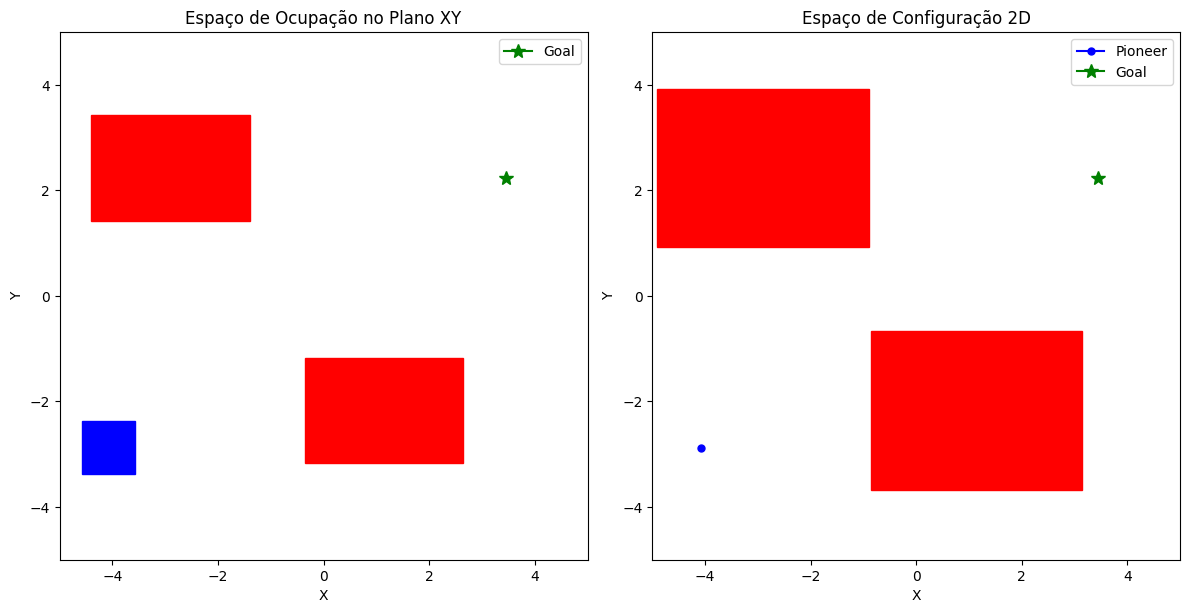

In [3]:
# Criar os subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Espaço de ocupação no primeiro subplot
for rect in rectangles:
    x, y, width, height = rect
    ax1.add_patch(plt.Rectangle((x - width/2, y - height/2), width, height, edgecolor='r', facecolor='r'))  # Retângulos sólidos

# Marcar a posição do Pioneer com um quadrado azul
pioneer_square = plt.Rectangle((pioneer_pos[0] - 0.5, pioneer_pos[1] - 0.5), 1, 1, edgecolor='blue', facecolor='blue')
ax1.add_patch(pioneer_square)

# Marcar a posição do Goal com uma estrela verde
ax1.plot(goal_pos[0], goal_pos[1], marker='*', color='green', markersize=10, label='Goal')

ax1.set_xlim(-5, 5)  # Ajuste os limites conforme necessário
ax1.set_ylim(-5, 5)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Espaço de Ocupação no Plano XY')
ax1.set_aspect('equal', adjustable='box')

# Adicionar legenda ao primeiro subplot
ax1.legend()

print(rectangles)
# Espaço de configuração no segundo subplot
for rect in rectangles:
    x, y, width, height = rect
    width = width + 1
    height = height + 1
    ax2.add_patch(plt.Rectangle((x - width/2, y - height/2), width, height, edgecolor='r', facecolor='r'))  # Retângulos sólidos

# Marcar a posição do Pioneer com um triângulo azul
ax2.plot(pioneer_pos[0], pioneer_pos[1], marker='.', color='blue', markersize=10, label='Pioneer')

# Marcar a posição do Goal com uma estrela verde
ax2.plot(goal_pos[0], goal_pos[1], marker='*', color='green', markersize=10, label='Goal')

ax2.set_xlim(-5, 5)  # Ajuste os limites conforme necessário
ax2.set_ylim(-5, 5)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Espaço de Configuração 2D')
ax2.set_aspect('equal', adjustable='box')

# Adicionar legenda ao segundo subplot
ax2.legend()

# Ajustar o layout para melhor visualização
plt.tight_layout()

plt.show()


[-4.07541323 -2.87509918]
[3.45000005 2.2249999 ]
Resultado com: 70


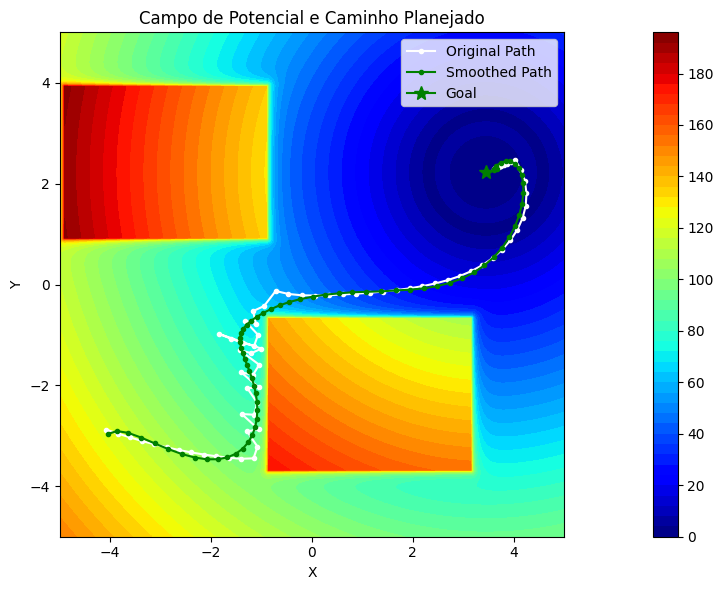

Program started
Connected to remote API server


KeyboardInterrupt: 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

pioneer_pos = np.array(pioneer_pos[0:2])
goal_pos = np.array(goal_pos[0:2])


print(pioneer_pos)
print(goal_pos)  # [3.45000005 2.2249999 ]

xi = 15
eta = 2
Q_star = 1.0
R_switch = 1

x = np.linspace(-5, 5, 3000)
y = np.linspace(-5, 5, 3000)
X, Y = np.meshgrid(x, y)

def attractive_potential(X, Y, goal, R_switch, xi):
    dist = np.sqrt((X - goal[0])**2 + (Y - goal[1])**2)
    U_att = np.zeros_like(dist)

    mask_conic = dist > R_switch
    U_att[mask_conic] = xi * (dist[mask_conic] - R_switch)

    mask_paraboloid = dist <= R_switch
    U_att[mask_paraboloid] = 0.5 * xi * dist[mask_paraboloid]**2

    return U_att

def repulsive_potential(X, Y, obstacles, Q_star, eta):
    U_rep = np.zeros_like(X)
    for rect in obstacles:
        x, y, width, height = rect
        dist_x = np.maximum(0, np.abs(X - x) - ((width +1)/ 2))
        dist_y = np.maximum(0, np.abs(Y - y) - ((height +1) / 2))
        dist = np.sqrt(dist_x**2 + dist_y**2)
        mask = dist < Q_star
        U_rep[mask] += 0.5 * eta * (1.0 / (dist[mask] + 0.1) - 1.0 / Q_star)**2
    return U_rep

U_att = attractive_potential(X, Y, goal_pos, R_switch, xi)
U_rep = repulsive_potential(X, Y, rectangles, Q_star, eta)
U_tot = U_att + U_rep

grad_U_x, grad_U_y = np.gradient(U_tot, x, y)

def calculate_tangential_force(grad):
    tangential_force = np.array([-grad[1], grad[0]])
    return tangential_force / np.linalg.norm(tangential_force)

path = [pioneer_pos.copy()]
current_pos = pioneer_pos.copy()
alpha = 0.01
beta = 20
threshold = 0.2
max_try = 0


while np.linalg.norm(current_pos - goal_pos) > threshold:
    ix = np.argmin(np.abs(x - current_pos[0]))
    iy = np.argmin(np.abs(y - current_pos[1]))

    grad = np.array([grad_U_y[iy, ix],grad_U_x[iy, ix]])

    repulsive_force = -grad
    if np.linalg.norm(current_pos - goal_pos) > 0.7:
        tangential_force = calculate_tangential_force(grad)
    else:
        tangential_force = 0
    total_force = repulsive_force + beta * tangential_force

    current_pos += alpha * total_force

    current_pos[0] = np.clip(current_pos[0], -4.8, 4.8)
    current_pos[1] = np.clip(current_pos[1], -4.8, 4.8)

    path.append(current_pos.copy())

    max_try += 1
    if max_try > 1000:
        break

print(f"Resultado com: {max_try}")


path = np.array(path)

window_length = 51 
polyorder = 7  

smoothed_path_x = savgol_filter(path[:, 0], window_length, polyorder)
smoothed_path_y = savgol_filter(path[:, 1], window_length, polyorder)
smoothed_path = np.vstack((smoothed_path_x, smoothed_path_y)).T

fig, ax3 = plt.subplots(1, 1, figsize=(18, 6))

c = ax3.contourf(X, Y, U_tot, levels=50, cmap='jet')
ax3.plot(path[:, 0], path[:, 1], marker='.', color='white', label='Original Path')
ax3.plot(smoothed_path[:, 0], smoothed_path[:, 1], marker='.', color='green', label='Smoothed Path')
ax3.plot(goal_pos[0], goal_pos[1], marker='*', color='green', markersize=10, label='Goal')

ax3.set_xlim(-5, 5)
ax3.set_ylim(-5, 5)
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_title('Campo de Potencial e Caminho Planejado')
ax3.set_aspect('equal', adjustable='box')

ax3.legend()

fig.colorbar(c, ax=ax3)

plt.tight_layout()

plt.show()

import RobotLibrary

print('Program started')
sim.simxFinish(-1)
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)

if clientID != -1:
    print('Connected to remote API server')
    controller = RobotLibrary.RobotController(clientID)
    path_gen = RobotLibrary.PathGenerator()

    controller.set_goal(np.array([goal_pos[0],goal_pos[1],0]))

    qi = controller.get_robot_position()

    path_gen.send_generated_path(clientID, smoothed_path_x, smoothed_path_y)

    controller.control_loop(smoothed_path_x, smoothed_path_y, max_try, goal_pos)

    controller.plot_results(smoothed_path_x, smoothed_path_y, goal_pos)
    sim.simxFinish(clientID)
else:
    print('Failed connecting to remote API server')

print('Program ended')